## Mode conservation
Evaluation of how normal modes of motion are conserved:
* Between phosphorylated and non-phosphorylated structures
* Within phosphorylated structures
* Within non-phosphorylated structures

In [1]:
from pathlib import Path
from collections import Counter
import pandas as pd
import numpy as np
from collections import defaultdict

from math import isnan, sqrt
import statsmodels.formula.api as smf
import statsmodels.api as sm

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

out_path = Path("matching_mode_comparison")
out_path.mkdir(exist_ok=True)

def process_df(df):
    melted_df = pd.melt(df.dropna(axis=1))
    melted_df = melted_df.rename(columns={'variable':'mode','value':'similarity'})
    return melted_df

def get_logreg_data(input_df):
    """
    Wrangle data into a form appropiate for a linear model
    """
    logit_df = []
    columns = ["comparison_between_groups","comparison_within_p","mode_index_sqrt","similarity"]

    for idx, row in input_df.iterrows():
        comparison = row["comparison"]
        mode_index_sqrt = sqrt(row["mode"])
        similarity = row["similarity"]

        if comparison == "between_groups":
            is_comparison_between = 1
        else:
            is_comparison_between = 0

        if comparison == "within_phospho":
            is_comparison_within_p = 1
        else:
            is_comparison_within_p = 0

        newrow = [is_comparison_between, is_comparison_within_p, mode_index_sqrt, similarity]
        logit_df.append(newrow)

    logit_df = pd.DataFrame(logit_df, columns=columns)
    return logit_df

In [2]:
rmsips_df = pd.read_csv(Path("global_dynamics_overview") / "rmsips_df.csv",index_col=0)
rmsips_df_subset = rmsips_df[["phosphosite","median_between_groups","std_between_groups"]]

FileNotFoundError: [Errno 2] No such file or directory: 'global_dynamics_overview/rmsips_df.csv'

In [87]:
base_path = Path("../results/rmsip_nma_mode_matching")
subdirs = [x for x in base_path.iterdir() if x.is_dir()]
print(len(subdirs))

128


In [88]:
psite_to_rmsip = {}
for idx, row in rmsips_df_subset.iterrows():
    psite = row["phosphosite"]
    rmsip = row["median_between_groups"]
    psite_to_rmsip[psite] = rmsip


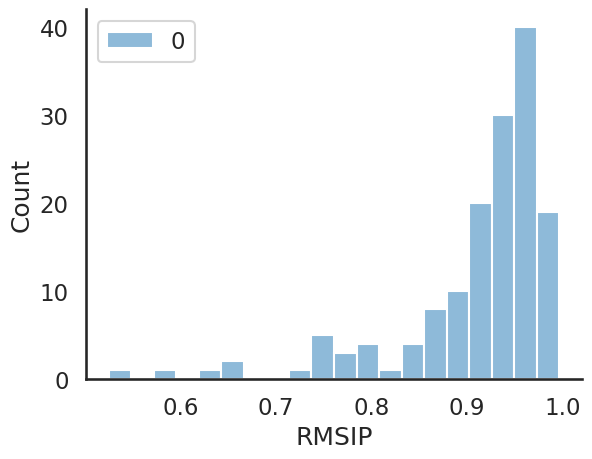

In [90]:
sns.set_context('talk')
sns.histplot(psite_to_rmsip.values())
plt.xlabel("RMSIP")
sns.despine()

In [92]:
rmsips_df_examples = rmsips_df[rmsips_df["median_between_groups"]>0.90].dropna().sort_values(by="median_between_groups")

In [94]:
rmsip_bin_to_mode_conservation_between = defaultdict(list)
rmsip_bin_to_mode_conservation_within_p = defaultdict(list)
rmsip_bin_to_mode_conservation_within_np = defaultdict(list)

rmsip_bins = [0.9, 0.8, 0.5]

for subdir in subdirs:
    try:
        psite = subdir.stem
        rmsip = psite_to_rmsip[psite]
        
        between_modes_df = pd.read_csv(subdir / "between_modes.csv",index_col=0)
        within_p_df = pd.read_csv(subdir / "within_phospho_modes.csv",index_col=0)
        within_np_df = pd.read_csv(subdir / "within_nonphospho_modes.csv",index_col=0)
        
        # Take the median RMSIP between matching modes
        between_median = list(between_modes_df.median(axis=0))
        if len(within_p_df) > 0:
            within_p_median = list(within_p_df.median(axis=0))
        else:
            within_p_median = []
        if len(within_np_df) > 0:
            within_np_median = list(within_np_df.median(axis=0))
        else:
            within_np_median = []
        
        for idx, bin_threshold in enumerate(rmsip_bins):
                # Special case (upper bin)
                if idx == 0:
                    if rmsip >= bin_threshold:
                        rmsip_bin_to_mode_conservation_between[bin_threshold].append(between_median)
                        if within_p_median:
                            rmsip_bin_to_mode_conservation_within_p[bin_threshold].append(within_p_median)
                        if within_np_median:
                            rmsip_bin_to_mode_conservation_within_np[bin_threshold].append(within_np_median)
                        break
                else:
                    if rmsip >= bin_threshold and rmsip < rmsip_bins[idx-1]:
                        rmsip_bin_to_mode_conservation_between[bin_threshold].append(between_median)
                        if within_p_median:
                            rmsip_bin_to_mode_conservation_within_p[bin_threshold].append(within_p_median)
                        if within_np_median:
                            rmsip_bin_to_mode_conservation_within_np[bin_threshold].append(within_np_median)
                        break                
    except FileNotFoundError:
        print(f"Not found for {subdir.stem}")
        continue



In [96]:
# Turn them into dataframes
# For clarity, drop proteins that doesn't have at least 150 modes
# (the vast majority of them do)
rmsip_between_dfs = []
rmsip_within_p_dfs = []
rmsip_within_np_dfs = []

for key, df in rmsip_bin_to_mode_conservation_between.items():
    rmsip_between_dfs.append(pd.DataFrame(df).dropna(axis=0, thresh=150))

for key, df in rmsip_bin_to_mode_conservation_within_p.items():
    rmsip_within_p_dfs.append(pd.DataFrame(df).dropna(axis=0, thresh=150))

for key, df in rmsip_bin_to_mode_conservation_within_np.items():
    rmsip_within_np_dfs.append(pd.DataFrame(df).dropna(axis=0, thresh=150))


In [97]:
# How many per group?
for key, df in rmsip_bin_to_mode_conservation_between.items():
    print(key)
    print(len(df))

0.9
100
0.8
18
0.5
10


In [98]:
# Prepare the dataframes for plotting
melted_between_dfs = [process_df(df) for df in rmsip_between_dfs]
melted_within_p_dfs = [process_df(df) for df in rmsip_within_p_dfs]
melted_within_np_dfs = [process_df(df) for df in rmsip_within_np_dfs]

bin_names = list(rmsip_bin_to_mode_conservation_between.keys())
for idx, df in enumerate(melted_between_dfs):
    df["group"] = bin_names[idx]

for idx, df in enumerate(melted_within_p_dfs):
    df["group"] = bin_names[idx]

for idx, df in enumerate(melted_within_np_dfs):
    df["group"] = bin_names[idx]


In [99]:
# Comparison between phospho and non-phospho, all similarity bins
concat_between_df = pd.concat(melted_between_dfs)
# Comparison within phospho, all similarity bins
concat_within_p_df = pd.concat(melted_within_p_dfs)
# Comparison within non-phospho, all similarity bins
concat_within_np_df = pd.concat(melted_within_np_dfs)


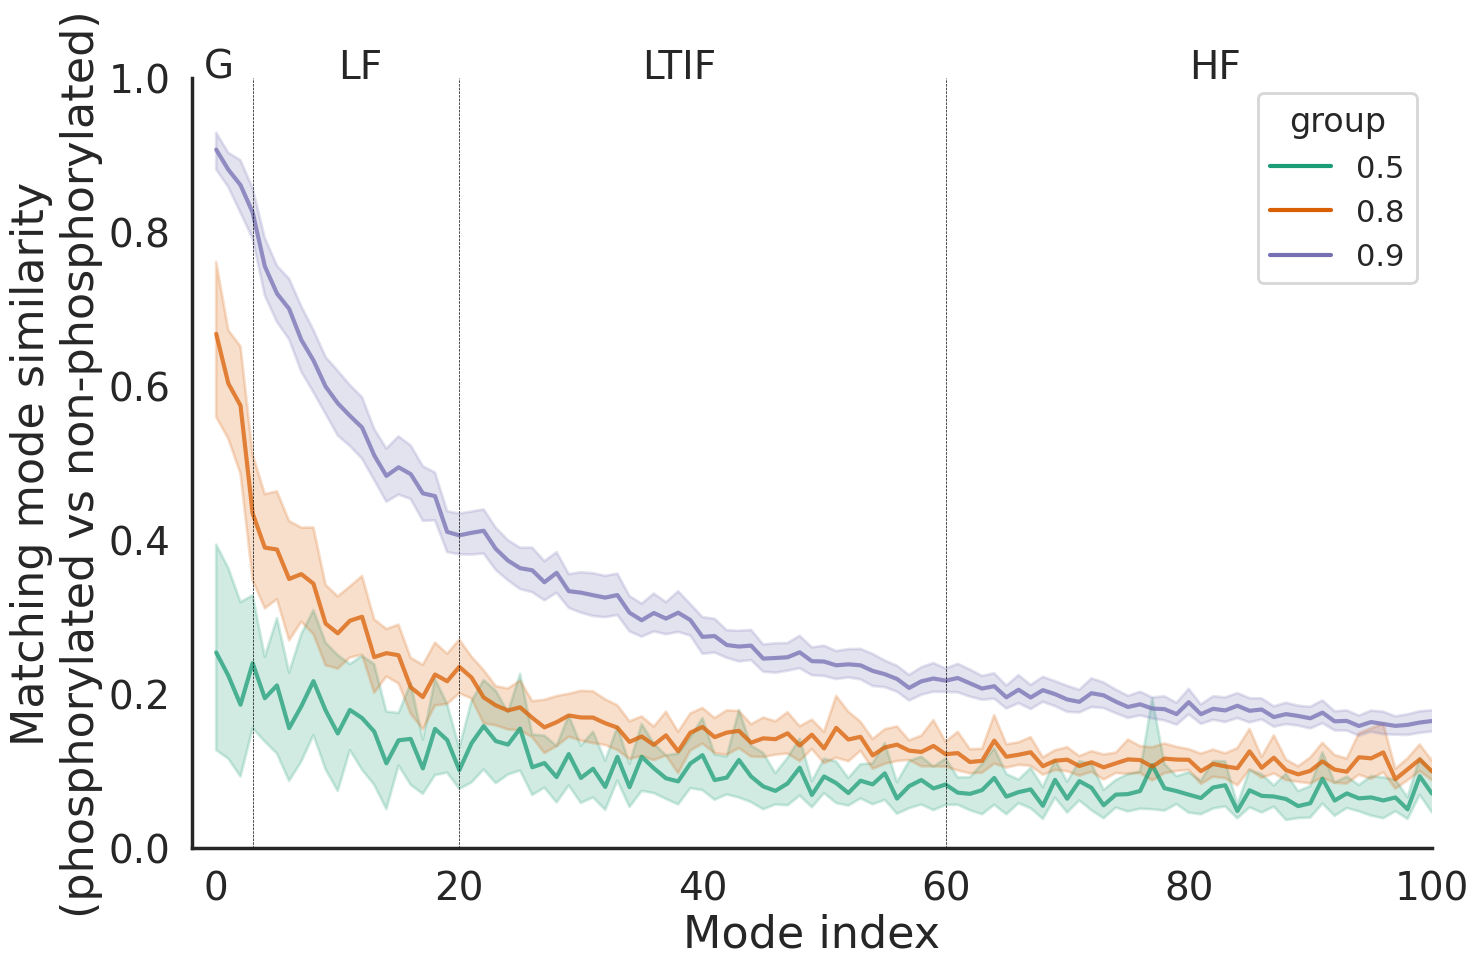

In [102]:
sns.set_style('white')
sns.set_context('poster',rc={"xtick.labelsize":28,"ytick.labelsize":28})

plt.figure(figsize=(16,10))
sns.lineplot(data=concat_between_df,x="mode",y="similarity",hue="group",alpha=0.75,palette="Dark2")
plt.xlim(-2,100)
plt.ylim(0,1)

plt.axvline(3,ls='--',color='black',lw=0.5)
plt.axvline(20,ls='--',color='black',lw=0.5)
plt.axvline(60,ls='--',color='black',lw=0.5)

plt.text(-1,1,"G",fontsize=28)
plt.text(10,1,"LF",fontsize=28)
plt.text(35,1,"LTIF",fontsize=28)
plt.text(80,1,"HF",fontsize=28)

plt.ylabel('Matching mode similarity\n(phosphorylated vs non-phosphorylated)',fontsize=32)
plt.xlabel("Mode index",fontsize=32)

sns.despine()
#plt.suptitle("Mode similarities (phosphorylated vs non-phosphorylated)")

plt.savefig(out_path / "between_groups_comparison.pdf",dpi=120,bbox_inches='tight')

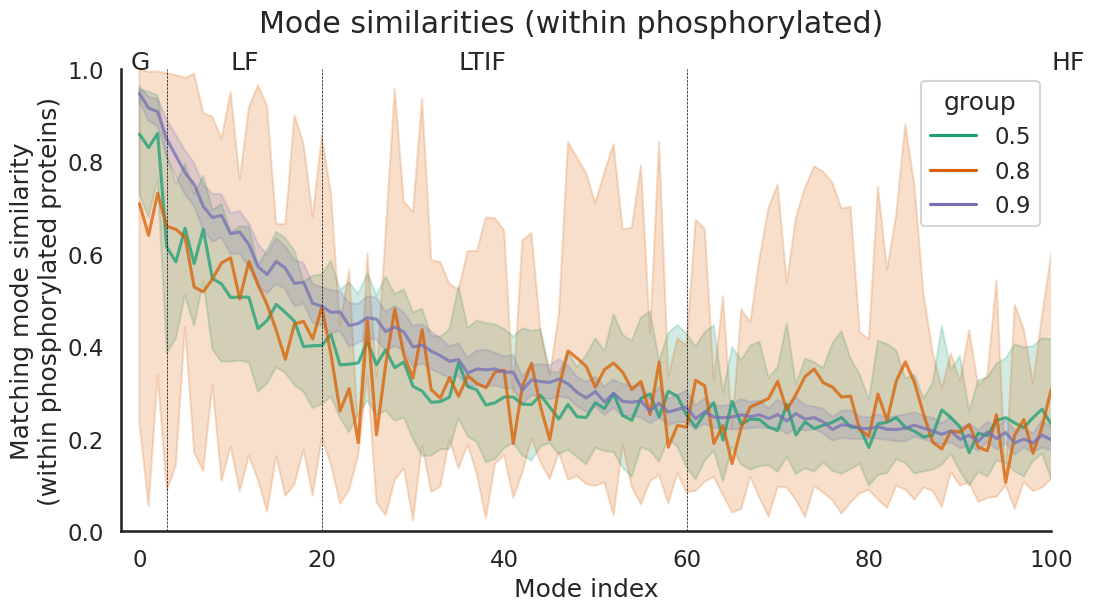

In [103]:
sns.set_style('white')
sns.set_context('talk')

plt.figure(figsize=(12,6))
sns.lineplot(data=concat_within_p_df,x="mode",y="similarity",hue="group",alpha=0.75,palette="Dark2")

plt.xlim(-2,100)
plt.ylim(0,1)

plt.axvline(3,ls='--',color='black',lw=0.5)
plt.axvline(20,ls='--',color='black',lw=0.5)
plt.axvline(60,ls='--',color='black',lw=0.5)

plt.text(-1,1,"G")
plt.text(10,1,"LF")
plt.text(35,1,"LTIF")
plt.text(100,1,"HF")

plt.ylabel('Matching mode similarity\n(within phosphorylated proteins)')
plt.xlabel("Mode index")
plt.suptitle("Mode similarities (within phosphorylated)")


sns.despine()
plt.savefig(out_path / "within_phospho_comparison.pdf",dpi=120,bbox_inches='tight')

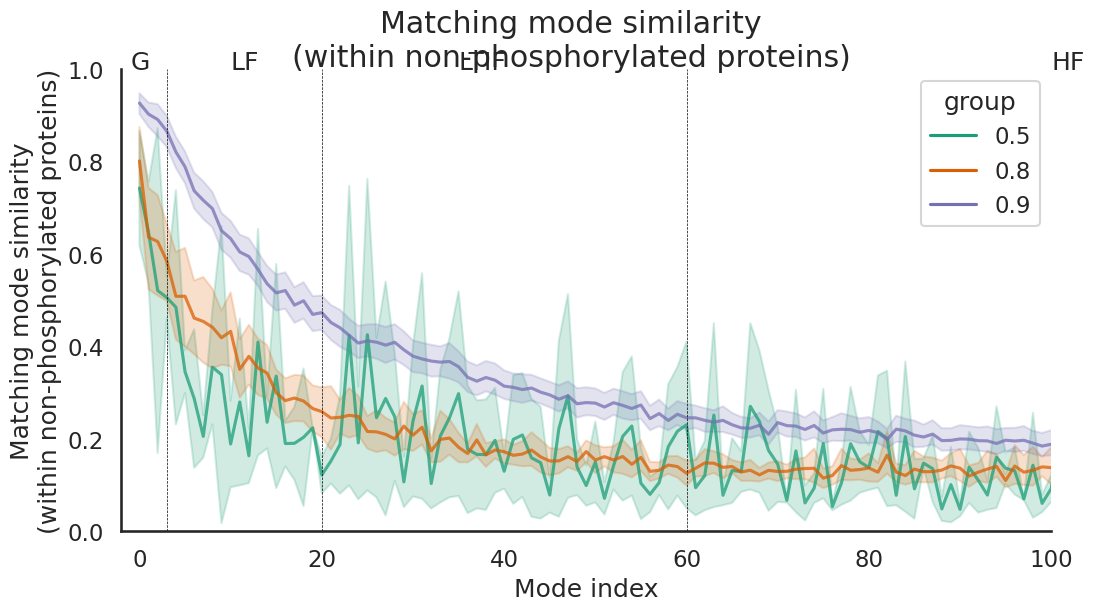

In [104]:
sns.set_style('white')
sns.set_context('talk')

plt.figure(figsize=(12,6))
sns.lineplot(data=concat_within_np_df,x="mode",y="similarity",hue="group",alpha=0.75,palette="Dark2")

plt.xlim(-2,100)
plt.ylim(0,1)

plt.axvline(3,ls='--',color='black',lw=0.5)
plt.axvline(20,ls='--',color='black',lw=0.5)
plt.axvline(60,ls='--',color='black',lw=0.5)

plt.text(-1,1,"G")
plt.text(10,1,"LF")
plt.text(35,1,"LTIF")
plt.text(100,1,"HF")

plt.ylabel('Matching mode similarity\n(within non-phosphorylated proteins)')
plt.xlabel("Mode index")
plt.suptitle('Matching mode similarity\n(within non-phosphorylated proteins)')

sns.despine()
plt.savefig(out_path / "within_nonphospho_comparison.pdf",dpi=120,bbox_inches='tight')

In [105]:
between_90 = concat_between_df.loc[concat_between_df["group"] == 0.9]
within_p_90 = concat_within_p_df.loc[concat_within_p_df["group"] == 0.9]
within_np_90 = concat_within_np_df.loc[concat_within_np_df["group"] == 0.9]

between_90["comparison"] = "between_groups"
within_p_90["comparison"] = "within_phospho"
within_np_90["comparison"] = "within_nonphospho"

df_90 = pd.concat([between_90,within_p_90,within_np_90])

/tmp/ipykernel_136881/2654256284.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  between_90["comparison"] = "between_groups"
/tmp/ipykernel_136881/2654256284.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  within_p_90["comparison"] = "within_phospho"
/tmp/ipykernel_136881/2654256284.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/p

In [106]:
color_palette=[sns.color_palette("Set1")[2],sns.color_palette("Set1")[4],sns.color_palette("Set1")[1]]

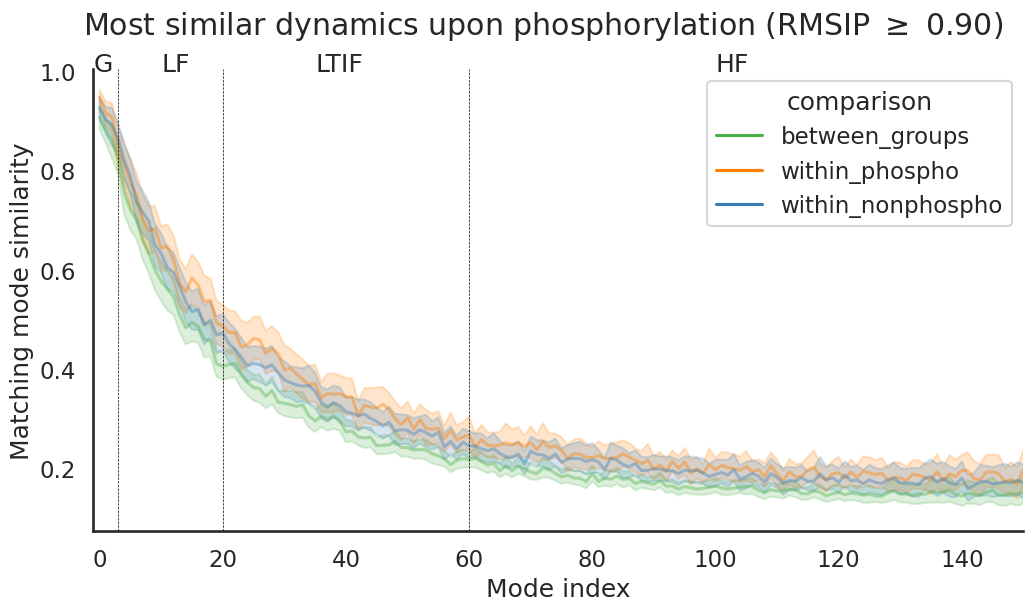

In [140]:
sns.set_style('white')
sns.set_context('talk')

plt.figure(figsize=(12,6))
sns.lineplot(data=test_df,x="mode",y="similarity",hue="comparison",alpha=0.4,palette=color_palette)
#plt.ylim(0.2,0.8)
plt.xlim(-1,150)


plt.axvline(3,ls='--',color='black',lw=0.5)
plt.axvline(20,ls='--',color='black',lw=0.5)
plt.axvline(60,ls='--',color='black',lw=0.5)

plt.text(-1,1,"G")
plt.text(10,1,"LF")
plt.text(35,1,"LTIF")
plt.text(100,1,"HF")


plt.ylabel("Matching mode similarity")
plt.xlabel("Mode index")
plt.suptitle(r'Most similar dynamics upon phosphorylation (RMSIP $\geq$ 0.90)')

sns.despine()
plt.savefig(out_path / "comparison_above_90.pdf",dpi=120,bbox_inches='tight')

In [108]:
logit_test = []
columns = ["comparison_between_groups","comparison_within_p","mode_index","mode_index_sqrt","similarity"]

for idx, row in test_df.iterrows():
    comparison = row["comparison"]
    mode_index_sqrt = np.sqrt(row["mode"])
    mode_index = row["mode"]
    
    similarity = row["similarity"]
    
    if comparison == "between_groups":
        is_comparison_between = 1
    else:
        is_comparison_between = 0
    
    if comparison == "within_phospho":
        is_comparison_within_p = 1
    else:
        is_comparison_within_p = 0
        
    newrow = [is_comparison_between, is_comparison_within_p, mode_index, mode_index_sqrt, similarity]
    logit_test.append(newrow)
    
logit_test = pd.DataFrame(logit_test, columns=columns)

In [109]:
over90model = smf.ols('similarity ~ comparison_between_groups + comparison_within_p + mode_index_sqrt', data=logit_test).fit()
over90model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             similarity   R-squared:                       0.419
Model:                            OLS   Adj. R-squared:                  0.419
Method:                 Least Squares   F-statistic:                 1.256e+04
Date:                Mon, 05 Aug 2024   Prob (F-statistic):               0.00
Time:                        14:36:02   Log-Likelihood:                 21869.
No. Observations:               52224   AIC:                        -4.373e+04
Df Residuals:                   52220   BIC:                        -4.369e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     0.6360      0.002    277.034      0.000       0.631       0.640
comparison_between_groups    -0.0299      0.002    -18.026      0.000      -0.033      -0.027
comparison_within_p           0.0155      0.002      8.702      0.000       0.012       0.019
mode_index_sqrt              -0.0395      0.000   -192.210      0.000      -0.040      -0.039
==============================================================================
Omnibus:                    19308.134   Durbin-Watson:                   1.498
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            80494.258
Skew:                           1.807   Prob(JB):                         0.00
Kurtosis:                       7.891   Cond. No.                         38.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [134]:
for x in range (0, 4):
    print(over90model.pvalues[x])

0.0
2.0245267247833567e-72
3.356353617164534e-18
0.0


In [110]:
between_80 = concat_between_df.loc[concat_between_df["group"] == 0.8]
within_p_80 = concat_within_p_df.loc[concat_within_p_df["group"] == 0.8]
within_np_80 = concat_within_np_df.loc[concat_within_np_df["group"] == 0.8]

between_80["comparison"] = "between_groups"
within_p_80["comparison"] = "within_phospho"
within_np_80["comparison"] = "within_nonphospho"

over80_df = pd.concat([between_80,within_p_80,within_np_80])
over80model_df = get_logreg_data(over80_df)

/tmp/ipykernel_136881/2121423879.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  between_80["comparison"] = "between_groups"
/tmp/ipykernel_136881/2121423879.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  within_p_80["comparison"] = "within_phospho"
/tmp/ipykernel_136881/2121423879.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/p

In [112]:
over80model = smf.ols('similarity ~ comparison_between_groups + comparison_within_p + mode_index_sqrt', data=over80model_df).fit()


In [113]:
over80model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             similarity   R-squared:                       0.259
Model:                            OLS   Adj. R-squared:                  0.259
Method:                 Least Squares   F-statistic:                     679.8
Date:                Mon, 05 Aug 2024   Prob (F-statistic):               0.00
Time:                        14:36:08   Log-Likelihood:                 2892.4
No. Observations:                5829   AIC:                            -5777.
Df Residuals:                    5825   BIC:                            -5750.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     0.3711      0.006     61.970      0.000       0.359       0.383
comparison_between_groups    -0.0352      0.004     -8.504      0.000      -0.043      -0.027
comparison_within_p           0.1919      0.006     30.021      0.000       0.179       0.204
mode_index_sqrt              -0.0221      0.001    -34.721      0.000      -0.023      -0.021
==============================================================================
Omnibus:                     2222.439   Durbin-Watson:                   1.836
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10739.543
Skew:                           1.794   Prob(JB):                         0.00
Kurtosis:                       8.599   Cond. No.                         31.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

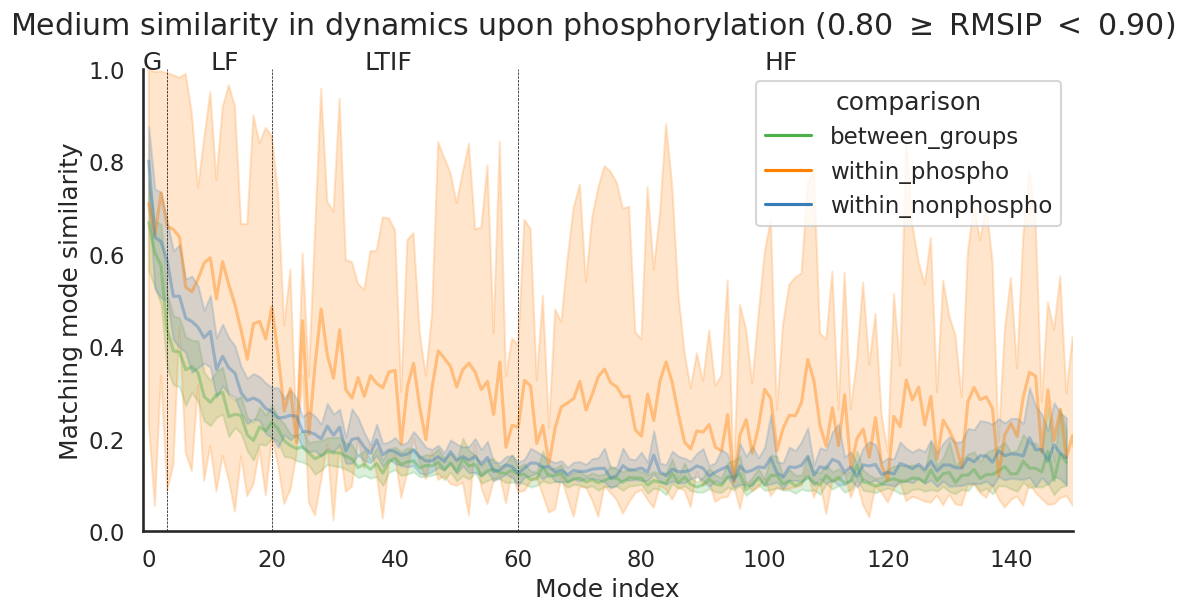

In [125]:
sns.set_style('white')
sns.set_context('talk')

plt.figure(figsize=(12,6))
sns.lineplot(data=over80_df,x="mode",y="similarity",hue="comparison",alpha=0.4, palette=color_palette)
#plt.ylim(0.2,0.8)
plt.xlim(-1,150)
plt.ylim(0,1)

plt.axvline(3,ls='--',color='black',lw=0.5)
plt.axvline(20,ls='--',color='black',lw=0.5)
plt.axvline(60,ls='--',color='black',lw=0.5)

plt.text(-1,1,"G")
plt.text(10,1,"LF")
plt.text(35,1,"LTIF")
plt.text(100,1,"HF")

plt.ylabel("Matching mode similarity")
plt.xlabel("Mode index")
plt.suptitle(r'Medium similarity in dynamics upon phosphorylation (0.80 $\geq$ RMSIP $<$ 0.90)')

sns.despine()
plt.savefig(out_path / "comparison_above_80.pdf",dpi=120,bbox_inches='tight')

In [126]:
between_50 = concat_between_df.loc[concat_between_df["group"] == 0.5]
within_p_50 = concat_within_p_df.loc[concat_within_p_df["group"] == 0.5]
within_np_50 = concat_within_np_df.loc[concat_within_np_df["group"] == 0.5]

In [127]:
between_50["comparison"] = "between_groups"
within_p_50["comparison"] = "within_phospho"
within_np_50["comparison"] = "within_nonphospho"

over50_df = pd.concat([between_50,within_p_50,within_np_50])
over50model_df = get_logreg_data(over50_df)


/tmp/ipykernel_136881/3732750268.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  between_50["comparison"] = "between_groups"
/tmp/ipykernel_136881/3732750268.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  within_p_50["comparison"] = "within_phospho"
/tmp/ipykernel_136881/3732750268.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/p

In [128]:
over50model = smf.ols('similarity ~ comparison_between_groups + comparison_within_p + mode_index_sqrt', data=over50model_df).fit()


In [129]:
over50model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             similarity   R-squared:                       0.196
Model:                            OLS   Adj. R-squared:                  0.195
Method:                 Least Squares   F-statistic:                     358.8
Date:                Mon, 05 Aug 2024   Prob (F-statistic):          1.38e-208
Time:                        15:28:56   Log-Likelihood:                 1336.2
No. Observations:                4428   AIC:                            -2664.
Df Residuals:                    4424   BIC:                            -2639.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     0.2521      0.011     22.043      0.000       0.230       0.275
comparison_between_groups    -0.0531      0.009     -6.029      0.000      -0.070      -0.036
comparison_within_p           0.1114      0.009     11.804      0.000       0.093       0.130
mode_index_sqrt              -0.0081      0.001    -10.378      0.000      -0.010      -0.007
==============================================================================
Omnibus:                     1838.218   Durbin-Watson:                   1.696
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7173.151
Skew:                           2.084   Prob(JB):                         0.00
Kurtosis:                       7.638   Cond. No.                         59.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

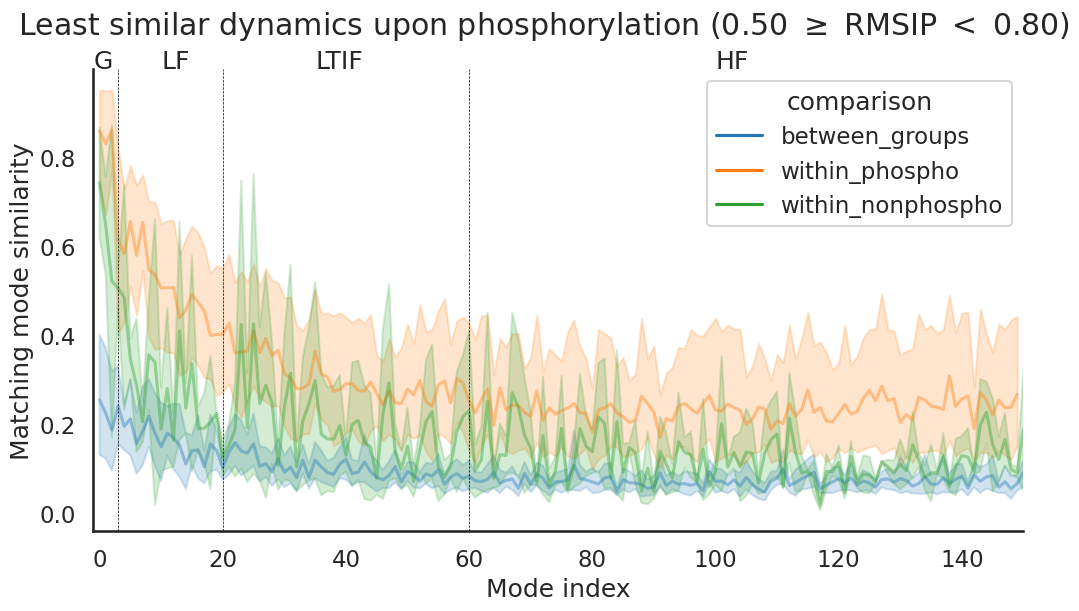

In [131]:
sns.set_style('white')
sns.set_context('talk')

plt.figure(figsize=(12,6))
sns.lineplot(data=over50_df,x="mode",y="similarity",hue="comparison",alpha=0.4,)
#plt.ylim(0.2,0.8)
plt.xlim(-1, 150)

plt.axvline(3,ls='--',color='black',lw=0.5)
plt.axvline(20,ls='--',color='black',lw=0.5)
plt.axvline(60,ls='--',color='black',lw=0.5)

plt.text(-1,1,"G")
plt.text(10,1,"LF")
plt.text(35,1,"LTIF")
plt.text(100,1,"HF")


plt.ylabel("Matching mode similarity")
plt.xlabel("Mode index")
plt.suptitle(r'Least similar dynamics upon phosphorylation (0.50 $\geq$ RMSIP $<$ 0.80)')


sns.despine()
plt.savefig(out_path / "comparison_below_50.pdf",dpi=120,bbox_inches='tight')

In [ ]:
sns.set_context('talk')
sns.set_style('white')

plt.figure(figsize=(12,5))
sns.lineplot(data=melted_between,x="mode",y="conservation",hue="group")

sns.despine()
#plt.xlim(-0.5,100)

# Global -> 1 to 3
# Low frequency -> 4 to 20 LF
plt.axvline(3,ls='--',color='black',alpha=0.25)
# Low-to-intermediate frequency (21 to 60) LTIF
plt.axvline(20,ls='--',color='black',alpha=0.25)
# High frequency > 60 HF
plt.axvline(60,ls='--',color='black',alpha=0.25)

plt.text(-4,  1.1,  "G")
plt.text(10, 1.1,  "LF")
plt.text(40, 1.1,  "LTIF")
plt.text(80, 1.1,  "HF")

plt.ylim(0,1)
plt.xlim(-4,melted_between["mode"].max())

#plt.xlim(0,100)
plt.xlabel("Mode")
plt.ylabel("Mode conservation")